In [1]:
import numpy as np
import xarray as xr

In [2]:
ds = xr.open_dataset('data1/out3.nc')

In [3]:
# 定数の設定，HoltonのAppendix Aなど，教科書を参照
a = 6.371e6  # 地球半径 m
g = 9.8  # 重力 m/s^2
omg = 7.292e-5  # 自転角速度 rad/s

In [4]:
# 緯度経度(latlon)に関するデータの整理
dlat, dlon = -1.25, 1.25  # deg
dlat, dlon = np.deg2rad(dlat), np.deg2rad(dlon)  # rad

# latlonのmeshgridの作成
lons2d, lats2d = np.meshgrid(ds['lon'], ds['lat'])  # deg

# 緯度ごとのcos
phi = np.deg2rad(lats2d)  # rad
cos_phi = np.cos(phi)

# 緯度毎のコリオリパラメタ (/s)
f = 2 * omg * np.sin(phi)
f = np.where(lats2d == 0., np.nan, f)  # 赤道の地衡風を計算しない

### np.gradientとnp.rollを用いた中央差分法の微分(近似)  
[note.nkmk.me - Numpy配列をシフト（スクロール）させるnp.roll](https://note.nkmk.me/python-numpy-roll/)  
球面座標系の微分 ($\lambda$:緯度, $\phi$:経度, 単位はラジアン)
$$
\frac{\partial}{\partial x} = \frac{1}{r \cos \lambda} \frac{\partial}{\partial \lambda} \\
\frac{\partial}{\partial y} = \frac{1}{r} \frac{\partial}{\partial \phi}
$$

In [5]:
#da = ds['z'].sel(lev=500).isel(time=0)
da = ds['z']

In [6]:
# axis     0,   1,   2,   3
# dims, time, lev, lat, lot

# np.rollで計算するとndarrayを生成する
dzdx = (np.roll(da, -1, axis=3) - np.roll(da, 1, axis=3)) / 2 / dlon / a / cos_phi
dzdy = (np.roll(da, -1, axis=2) - np.roll(da, 1, axis=2)) / 2 / dlat / a

# 極の値をnanに置換
dzdx = np.where((lats2d == -90)|(lats2d == 90), np.nan, dzdx)
dzdy = np.where((lats2d == -90)|(lats2d == 90), np.nan, dzdy)

# 地衡風の計算
ug = - dzdy * g / f
vg = dzdx * g / f

## Datasetの作成
[Python Tips & Memos by Physical Oceanography & Climate Laboratory in Hokkaido University - *make coords for xr.dataarray](https://sites.google.com/site/pythontipsmemo/kuo-zhangmojuru/xarray/make-netcdf-file)  
[xarray - Data Structures](https://xarray.pydata.org/en/stable/user-guide/data-structures.html)  

In [7]:
ds_out = xr.Dataset(
    data_vars={
        'ug': (da.dims, np.float32(ug), {'units': 'm/s'}),  # 元のDataArray(da)のdimensionsを継承
        'vg': (da.dims, np.float32(vg), {'units': 'm/s'})},  #　辞書はattrsになる
    coords=da.coords  # daのcoordinationを継承
)

# Datasetの保存
ds_out.to_netcdf('data1/out6.nc')

# 簡易的な作図（Cartopy）（中級者向け）
[scitools.org.uk cartopy - Using catrtopy with matplotlib](https://scitools.org.uk/cartopy/docs/latest/matplotlib/intro.html)  
[scitools.org.uk cartopy - Cartopy projection list](https://scitools.org.uk/cartopy/docs/latest/crs/projections.html)  
[Metpy Mondays - #6 Making a Basic Map with Cartopy](https://youtu.be/iPJjtU7OFSQ)  
[matplotlib - matplotlib.pyplot.quiver](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.quiver.html)  
[scitools.org.uk cartopy - Regridding vectors with quiver](https://scitools.org.uk/cartopy/docs/v0.17/gallery/regridding_arrows.html)

In [8]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

# 図をjupyterで表示するmagic
%matplotlib inline

In [58]:
ug2, vg2 = ds_out['ug'], ds_out['vg']

# dataメソッドでndarrayを生成，DataArrayのままだとエラー出る
ug2 = ug2.sel(lev=500).isel(time=1).data
vg2 = vg2.sel(lev=500).isel(time=1).data
z = da.sel(lev=500).isel(time=1).data

/Users/kasuga/opt/miniconda3/lib/python3.8/site-packages/cartopy/vector_transform.py:140: RuntimeWarning: invalid value encountered in cos
  u, v = target_proj.transform_vectors(src_crs, x, y, u, v)
/Users/kasuga/opt/miniconda3/lib/python3.8/site-packages/cartopy/vector_transform.py:140: RuntimeWarning: invalid value encountered in sin
  u, v = target_proj.transform_vectors(src_crs, x, y, u, v)


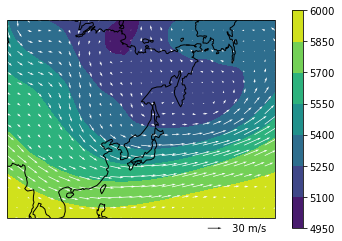

In [59]:
#mproj = ccrs.Orthographic(135, 45)  # quiverとの相性悪い？バグ？
mproj = ccrs.AzimuthalEquidistant(  # 作図用の投影, 正距方位図法
    central_longitude=135, central_latitude=45)
#mproj = ccrs.NorthPolarStereo()
dproj = ccrs.PlateCarree()  # データ格子の投影（緯度経度格子）

fig = plt.figure()  # figureの作成（机を用意するイメージ）
ax = fig.add_subplot(111, projection=mproj)  #axesの作成（机に画用紙を広げるイメージ）

ax.coastlines()  # 海岸線の描画

ax.set_extent([90, 180, 10, 80])  # 描画範囲の指定

w = (ug2**2+vg2**2)**(1/2)

# contourf はGrADSで言う set gxout shaded
#c = ax.contourf(lons2d, lats2d, w, transform=dproj)
c = ax.contourf(lons2d, lats2d, z, transform=dproj)  
plt.colorbar(c)

q = ax.quiver(lons2d, lats2d, ug2, vg2, regrid_shape=20,  # 風ベクトルの描画
              fc='w', transform=dproj)
ax.quiverkey(q, 0.8, -0.05, 30,' 30 m/s', fc='k', labelpos='E')  # 基準ベクトルの描画